In [1]:
import math

from tqdm.notebook import tqdm
tqdm.pandas()

from portfolio import Portfolio
from backtest import Backtest
from strategies import *
from config import *
from utils import plot_distribution
from data_processing import *

In [2]:
# get SPY data
spy_df = get_spy_data(start_date, end_date)
print("Number of days to backtest: ", len(spy_df))
spy_df.head(5)

Number of days to backtest:  250


,Date,Open,High,Low,Close,Adj Close,Volume
5535,2023-01-03,384.369995,386.429993,377.829987,380.820007,372.754303,74850700
5536,2023-01-04,383.179993,385.880005,380.000000,383.760010,375.632050,85934100
5537,2023-01-05,381.720001,381.839996,378.760010,379.380005,371.344727,76970500
5538,2023-01-06,382.609985,389.250000,379.410004,388.079987,379.860474,104189600
5539,2023-01-09,390.369995,393.700012,387.670013,387.859985,379.645142,73978100


In [3]:
# instantiation
my_portfolio = Portfolio(initial_portfolio_nominal_value, portolio_weights_config, collateral_ratio)
my_strategy = ZeroCostCollar0DTE(my_portfolio, 'SPY', spy_df)
env = Backtest(my_portfolio, spy_df)

# If price data is not available on Polygon.io, the BS model will be used to calculate price, which will print relevant info
if strategy == 1:
    my_strategy.add_zero_cost_collar(env.main_df, zero_cost_search_config, bs_config, 3, 'second', 'vwap')
elif strategy == 2:
    # select options based on config.strike_selection_config
    env.main_df = my_strategy.select_options(env.main_df, strike_selection_config)
    env.get_option_price('SPY', 3, 'second', 'vwap', 'open', bs_config)
else:
    raise ValueError("Check config, strategy does not exist. ")

env.update_option_price_at_close()
env.main_df = my_strategy.update_collar_pnl(env.main_df)

Searching for zero-cost collar: 100%|██████████| 250/250 [34:47<00:00,  8.35s/it] 


In [4]:
# Buy and hold SPY at market open on Day 0
first_date = env.main_df['Date'].values[0]
first_price = env.main_df['Open'].values[0]

target_spy_exposure = my_portfolio.initial_portfolio_nominal_value * my_portfolio.target_portfolio_weights['equity']
n_spy_to_buy = math.floor(target_spy_exposure / first_price)
my_strategy.execute_buy_and_hold_underlying('equity', first_date, first_price, n_spy_to_buy)

print('Portfolio position:', my_portfolio.positions)
print('Cash after buying SPY:', round(my_portfolio.cash, 2))
print('Transaction history')
my_portfolio.print_transaction_history()

Portfolio position: {'equity': {'SPY': 2341}}
Cash after buying SPY: 100189.84
Transaction history
2023-01-03: ['bought 2341 SPY at 384.37 on 2023-01-03.']


In [5]:
# Run the zero-cost collar strategy every day in spy_df
env.run(my_strategy)

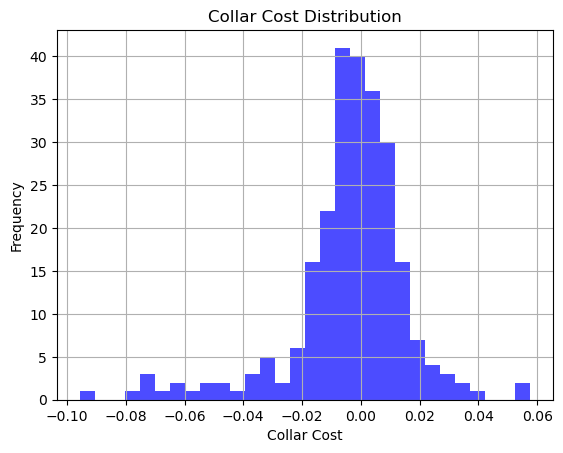

In [6]:
# Plot the distribution of collar strategy cost. Negative cost means the call premium is larger than put premium (i.e. receiving a credit to open)
plot_distribution(env.main_df['collar_cost'], x_label='Collar Cost', title='Collar Cost Distribution')

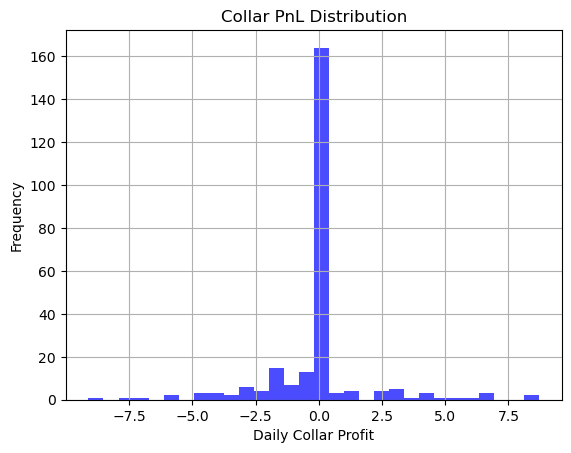

In [7]:
# Plot the distribution collar strategy PnL
plot_distribution(env.main_df['collar_pnl'], x_label='Daily Collar Profit', title='Collar PnL Distribution')

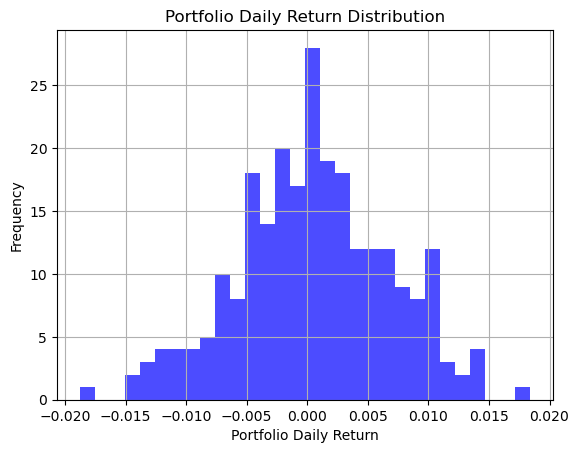

In [8]:
port_return = my_portfolio.calc_port_daily_return()
plot_distribution(port_return, x_label='Portfolio Daily Return', title='Portfolio Daily Return Distribution')

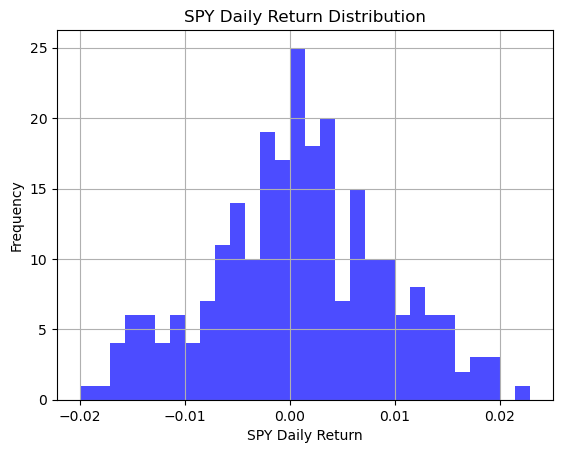

In [9]:
spy_return = env.calc_benchmark_return()
plot_distribution(spy_return, x_label='SPY Daily Return', title='SPY Daily Return Distribution')

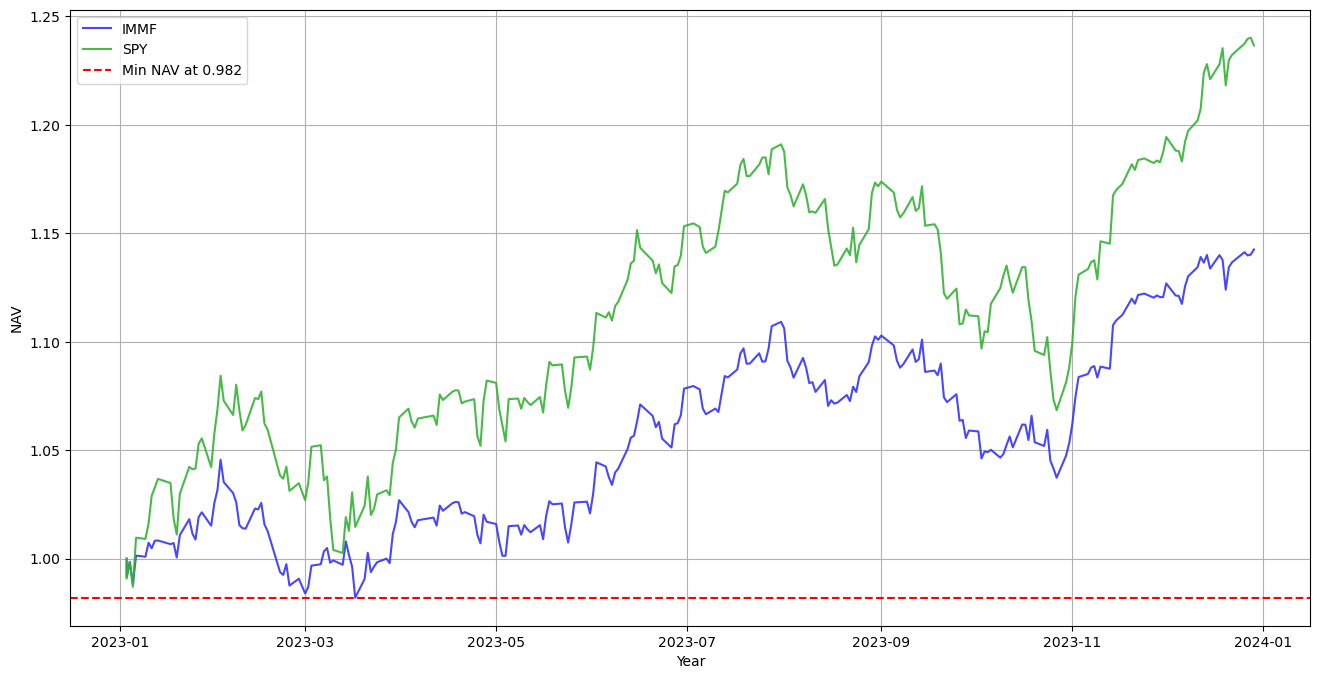

In [10]:
env.plot_nav_vs_spy()

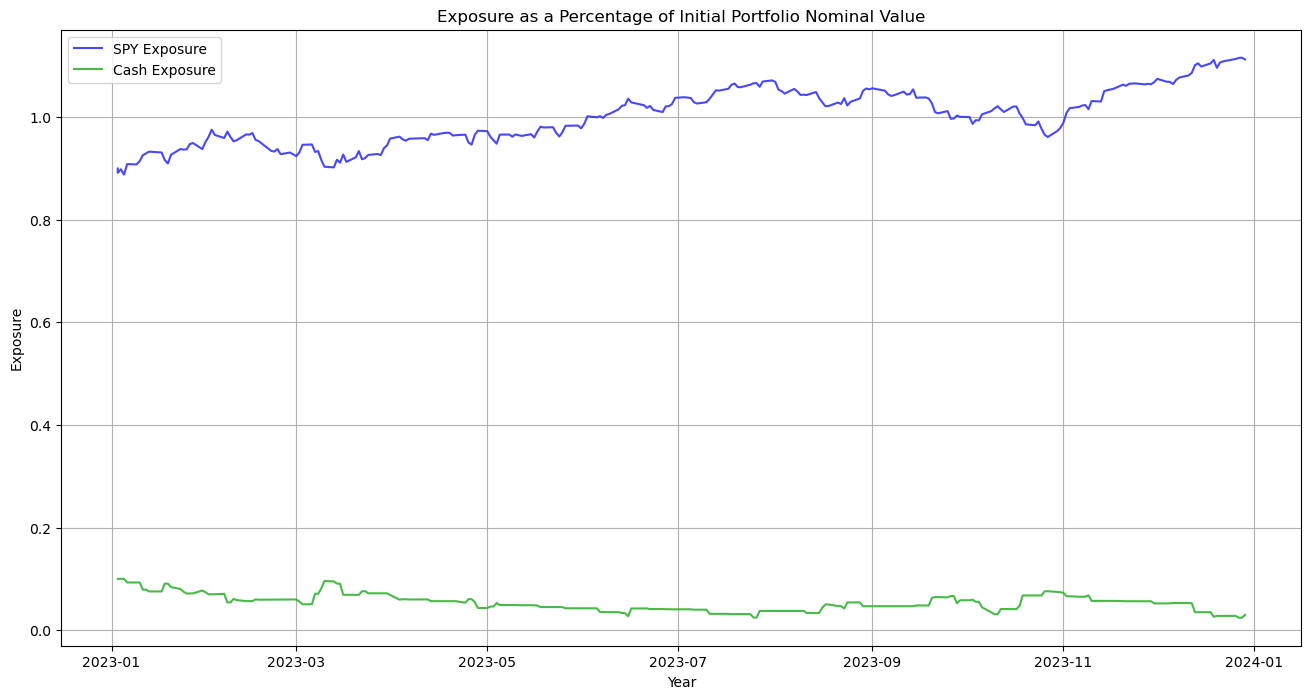

In [11]:
env.plot_exposure()

In [12]:
# my_portfolio.print_transaction_history()

In [14]:
env.save_main_df_to_csv()